## Данные: 
df - Данные по времени регистрации и авторизации пользователей мобильного приложения\

uid	- идентификационный номер пользователя\
reg_ts - дата регистрации\
auth_ts	- дата авторизации\

abdf - Результаты эксперимента для A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений.\

user_id	- id пользователя\
revenue	- доход \
testgroup - тестовая группа\

## Задачи:
Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).\

Имеются результаты эксперимента для A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.\
Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?


In [1]:
import pandas as pd
import numpy as np
from operator import attrgetter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
sns.set(font_scale = 2, style = 'darkgrid', rc = {'figure.figsize':(8, 8)})
from scipy.stats import chi2_contingency, chi2
import scipy.stats as ss
from tqdm.auto import tqdm
from scipy.stats import norm
plt.style.use('ggplot')

In [2]:
d1 = pd.read_csv('./problem1-auth_data.csv', sep = ';')
d2 = pd.read_csv('./problem1-reg_data.csv', sep = ';')
#открытие файлов

In [3]:
df= pd.merge(d1, d2, how = 'inner', on = 'uid')
#мердж

In [4]:
df.auth_ts = pd.to_datetime(pd.to_datetime(df.auth_ts,origin='unix', unit='s').dt.strftime('%Y-%m-%d'))
df.reg_ts = pd.to_datetime(pd.to_datetime(df.reg_ts,origin='unix', unit='s').dt.strftime('%Y-%m-%d'))
#приведение UNIX времени к формату год-месяц-день

In [5]:
df

,auth_ts,uid,reg_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-25,2,1999-07-22
3,1999-07-31,2,1999-07-22
4,1999-08-05,2,1999-07-22
...,...,...,...
9601008,2020-09-23,1110618,2020-09-23
9601009,2020-09-23,1110619,2020-09-23
9601010,2020-09-23,1110620,2020-09-23
9601011,2020-09-23,1110621,2020-09-23


# Retention

In [6]:
def retention(df, a = '', b = ''):

    rdf = df.query("reg_ts >= @a & reg_ts <= @b") #фильтрация по датам регистрации

    mdf = rdf.groupby(['reg_ts', 'auth_ts'], as_index=False).agg({'uid':'nunique'}) #группировка по датам регистрации и авторизации и расчет уникальных пользователей
    
    mdf['days_after_reg'] = (mdf.auth_ts - mdf.reg_ts).apply(attrgetter('days')) #расчет дней с дня регистрации
    mdf.reg_ts = mdf.reg_ts.dt.strftime('%Y-%m-%d')
    mdf = mdf.pivot(index = 'reg_ts', columns = 'days_after_reg', values = 'uid')#перестроение таблицы

    retention = mdf.divide(mdf.iloc[:, 0], axis = 0).style.format("{:.2%}", na_rep="") #расчет Retantion в процентах

    return retention



In [7]:
retention(df, '2020-08-01', '2020-08-31') #Ответ на Задание 1

days_after_reg,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
reg_ts,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-08-01,100.00%,1.92%,4.45%,4.31%,5.57%,5.91%,7.63%,6.37%,4.51%,6.37%,4.78%,5.11%,5.91%,4.71%,4.51%,4.91%,3.65%,4.45%,3.78%,4.11%,4.64%,3.38%,4.05%,3.78%,4.18%,4.11%,2.52%,3.12%,3.19%,3.05%,2.72%,2.79%,2.46%,2.65%,2.46%,2.39%,1.59%,2.46%,1.66%,1.73%,2.32%,1.19%,1.92%,1.53%,1.79%,1.39%,1.79%,0.73%,0.93%,1.59%,1.59%,1.19%,1.26%,0.86%
2020-08-02,100.00%,2.58%,4.04%,4.37%,5.17%,6.49%,6.63%,6.03%,4.51%,5.30%,5.50%,5.17%,4.57%,5.50%,4.64%,4.24%,4.97%,5.57%,4.51%,3.78%,3.91%,4.57%,3.84%,3.91%,3.98%,3.25%,3.38%,2.98%,3.38%,3.31%,2.65%,2.98%,2.25%,2.58%,2.52%,3.05%,2.05%,2.78%,1.86%,1.59%,2.05%,1.79%,1.19%,1.59%,1.46%,1.06%,1.33%,1.26%,1.33%,1.06%,1.66%,1.39%,0.40%,
2020-08-03,100.00%,1.72%,4.30%,4.03%,5.56%,6.15%,7.54%,5.29%,4.96%,4.89%,5.36%,5.09%,5.62%,5.62%,4.23%,3.84%,3.90%,4.96%,5.62%,3.84%,3.84%,4.10%,4.37%,2.98%,3.90%,3.17%,4.37%,3.37%,3.24%,2.58%,2.18%,3.51%,2.51%,2.98%,2.31%,2.12%,1.98%,2.18%,1.98%,2.18%,1.52%,1.59%,1.79%,1.52%,1.98%,1.79%,1.52%,1.46%,1.52%,1.12%,0.99%,0.93%,,
2020-08-04,100.00%,2.05%,3.57%,4.69%,5.22%,5.28%,6.47%,5.15%,4.43%,4.69%,5.28%,5.61%,4.03%,4.95%,3.57%,4.76%,5.09%,4.56%,4.36%,3.50%,4.10%,3.96%,3.04%,4.43%,2.91%,3.17%,2.97%,3.17%,2.64%,2.71%,2.18%,2.84%,2.51%,2.38%,2.51%,1.72%,1.78%,1.72%,2.05%,1.92%,1.72%,1.72%,1.12%,1.52%,1.65%,1.72%,1.32%,1.32%,1.45%,0.99%,0.79%,,,
2020-08-05,100.00%,2.57%,3.49%,4.02%,5.74%,5.08%,7.78%,6.13%,4.22%,4.75%,4.75%,5.67%,5.21%,4.81%,3.69%,3.76%,3.56%,4.61%,4.22%,3.69%,4.15%,3.36%,3.30%,3.30%,3.76%,2.97%,3.56%,2.77%,3.03%,3.10%,2.77%,2.44%,2.44%,2.24%,2.24%,2.24%,2.31%,1.45%,2.37%,1.78%,1.38%,1.25%,1.19%,1.32%,1.25%,1.58%,0.66%,1.05%,1.05%,0.53%,,,,
2020-08-06,100.00%,1.71%,5.07%,5.73%,5.60%,5.73%,7.50%,6.06%,5.00%,5.79%,5.13%,5.20%,4.87%,4.54%,4.74%,5.53%,4.21%,4.67%,4.21%,4.08%,4.15%,3.82%,3.88%,3.36%,3.82%,3.09%,2.90%,4.08%,3.16%,2.83%,2.90%,2.11%,2.76%,2.04%,2.50%,2.44%,1.71%,1.91%,1.32%,1.84%,1.38%,1.58%,1.05%,1.78%,1.18%,1.12%,1.12%,0.99%,1.12%,,,,,
2020-08-07,100.00%,2.17%,3.09%,5.26%,5.32%,5.98%,7.16%,6.18%,5.12%,4.99%,4.93%,5.72%,5.19%,4.66%,5.12%,4.14%,4.60%,4.53%,5.12%,4.14%,3.48%,4.73%,3.09%,3.81%,3.88%,3.55%,3.94%,2.37%,3.88%,2.96%,3.55%,3.02%,2.69%,2.96%,2.23%,2.89%,2.56%,1.71%,2.04%,2.10%,1.84%,1.77%,1.77%,1.45%,1.31%,1.45%,1.45%,0.85%,,,,,,
2020-08-08,100.00%,2.43%,4.79%,4.20%,5.45%,5.45%,7.22%,6.30%,3.94%,4.79%,5.25%,5.12%,4.00%,5.58%,4.86%,4.27%,4.27%,4.53%,3.41%,4.27%,4.33%,3.54%,4.33%,3.35%,4.00%,3.54%,2.62%,2.76%,3.15%,2.82%,2.23%,3.67%,1.57%,2.36%,2.82%,2.17%,2.30%,2.23%,1.64%,1.90%,1.12%,1.64%,1.51%,1.18%,1.38%,0.98%,0.72%,,,,,,,
2020-08-09,100.00%,2.10%,3.93%,4.65%,5.37%,7.07%,6.29%,6.61%,4.45%,4.91%,4.45%,6.22%,5.37%,5.63%,3.99%,4.65%,4.32%,5.30%,4.52%,4.58%,4.65%,3.93%,4.13%,3.73%,4.32%,3.14%,3.54%,3.54%,2.88%,3.67%,2.55%,3.27%,2.49%,2.29%,2.55%,2.42%,2.95%,2.10%,2.03%,2.82%,1.83%,2.29%,1.70%,1.70%,1.77%,0.98%,,,,,,,,


# A/B test

In [8]:
abdf = pd.read_csv('../shared/problem2.csv', sep = ';') #считываю данные

# Для начала посчитаю конверсию в покупку в обоих группах

In [9]:
abdf['Paying_user'] = abdf.revenue.apply(lambda x: True if x > 0 else False) 
#создаю колонку в которой True - плативший пользователь, False - нет.

In [10]:
abdf

,user_id,revenue,testgroup,Paying_user
0,1,0,b,False
1,2,0,a,False
2,3,0,a,False
3,4,0,b,False
4,5,0,b,False
...,...,...,...,...
404765,404766,0,a,False
404766,404767,0,b,False
404767,404768,231,a,True
404768,404769,0,a,False


In [11]:
round(abdf.query("testgroup == 'a' & Paying_user == True").Paying_user.count()/abdf.query("testgroup == 'a'").Paying_user.count() * 100, 2)
#CR группы a, %

0.95

In [12]:
round(abdf.query("testgroup == 'b' & Paying_user == True").Paying_user.count()/abdf.query("testgroup == 'b'").Paying_user.count() * 100, 2)
#CR группы b, %

0.89

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


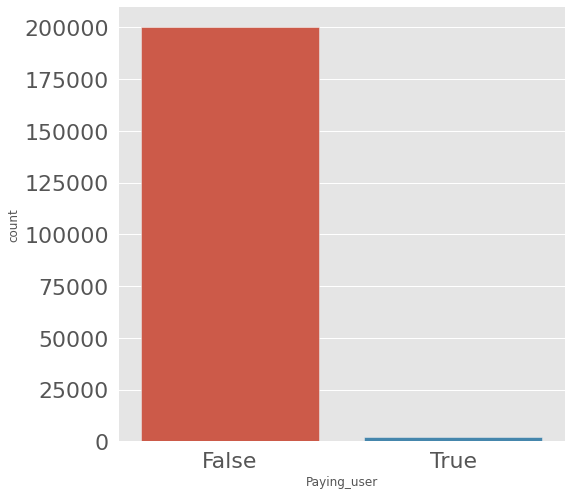

In [13]:
sns.countplot(abdf.query("testgroup == 'a'").Paying_user)
#Распределение платящих и неплатящих пользователей в группе а

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


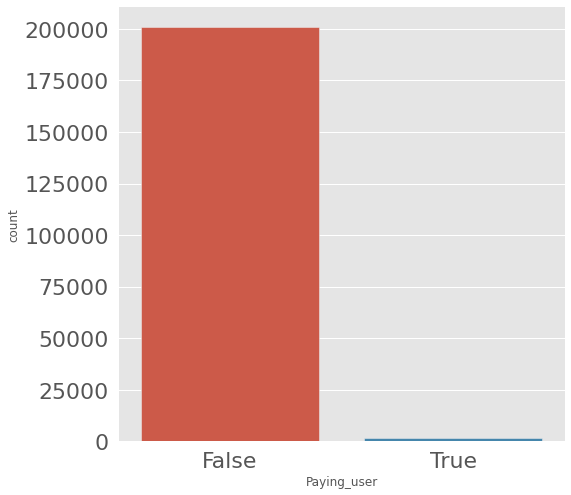

In [14]:
sns.countplot(abdf.query("testgroup == 'b'").Paying_user)
#Распределение платящих и неплатящих пользователей в группе b

Поскольку в АБ-тесте будут сравниваться номинативные переменные, буду применять метод Xu - квадрат. 

In [15]:
crospu = pd.crosstab(abdf.Paying_user, abdf.testgroup)
crospu
# подготавливаю перекрестную таблицу для АБ-теста

testgroup,a,b
Paying_user,,
False,200175,200862
True,1928,1805


In [16]:
stat, p, dof, expected = chi2_contingency(crospu)
if p <= 0.05:
    print('Отклоняем нулевую гипотезу, p-value = ', round(p, 3))
else:
    print('Принемаем нулевую гипотезу, p-value = ', round(p, 3))

Отклоняем нулевую гипотезу, p-value =  0.036


# Результат сравнения CR:
Нулевая гипотеза отклонена, а значит между группами обнаружена значимая разница. Следовательно конверсия группы А, статически значимо превышает конверсию группы B.

# Исследую ARPU

In [17]:
round(abdf[abdf.testgroup == 'a'].revenue.mean(), 3)
#ARPU группы а

25.414

In [18]:
round(abdf[abdf.testgroup == 'b'].revenue.mean(), 3)
#ARPU группы b

26.751

In [19]:
ss.normaltest(abdf[abdf.testgroup == 'a'].revenue)

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

In [20]:
ss.normaltest(abdf[abdf.testgroup == 'b'].revenue)

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)

Распределения ненормальные. Для тестирования буду использовать тест Манна-Уитни и Бутстрэп по среднему

In [21]:
ss.mannwhitneyu(abdf[abdf.testgroup == 'a'].revenue,
               abdf[abdf.testgroup == 'b'].revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

In [22]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

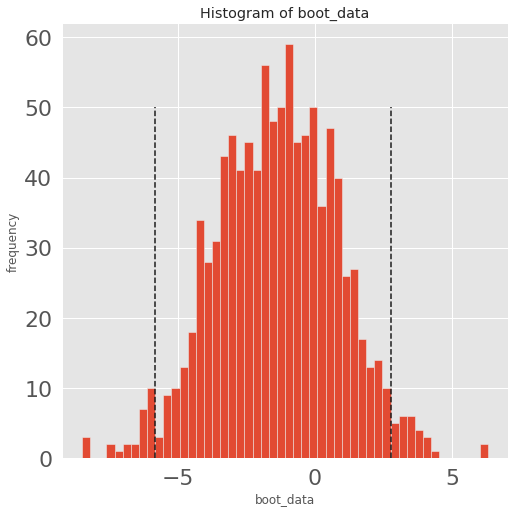

In [23]:
arpuTrap = get_bootstrap(abdf[abdf.testgroup == 'a'].revenue, abdf[abdf.testgroup == 'b'].revenue)

In [24]:
arpuTrap['p_value']

0.5266737786824911

# Результат сравнения ARPU:
Нулевая гипотеза принята, и тест Манна-Уитни и Бутстрэп показали p-val > 0.05, между группами  не обнаружено статически значимой разницы.

# Исследую ARPPU

In [25]:
round(abdf.query("testgroup == 'a' & Paying_user == True").revenue.mean(), 3)
#ARPPU группы a

2663.998

In [26]:
round(abdf.query("testgroup == 'b' & Paying_user == True").revenue.mean(), 3)
#ARPPU группы b

3003.658

In [27]:
ss.normaltest(abdf.query("testgroup == 'a' & Paying_user == True").revenue)

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

In [28]:
ss.normaltest(abdf.query("testgroup == 'b' & Paying_user == True").revenue)

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

Распределения ненормальные. Для сравнения буду использовать тест Манна-Уитни и Бутстрэп

In [29]:
ss.mannwhitneyu(abdf.query("testgroup == 'a' & Paying_user == True").revenue,
            abdf.query("testgroup == 'b' & Paying_user == True").revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

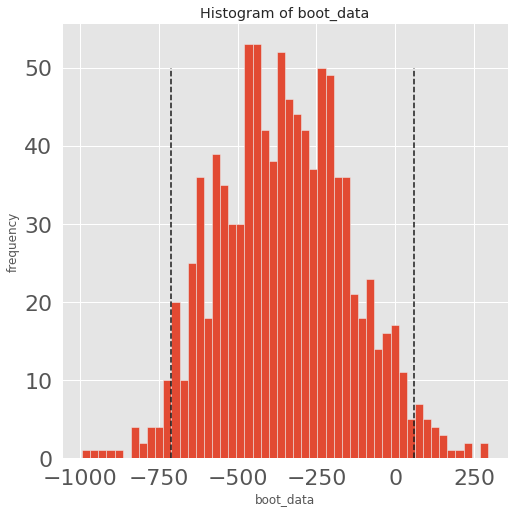

In [30]:
arppuTrap = get_bootstrap(abdf.query("testgroup == 'a' & Paying_user == True").revenue,
            abdf.query("testgroup == 'b' & Paying_user == True").revenue)

In [31]:
arppuTrap['p_value']

0.08716833685897678

# Результат сравнения ARPPU:
В данном случае U-критерий Манна-Уитни показал существование разницы между распределениями и p-val < 0.05, Бутстрэп же продемонстрировал p-val > 0.05 и принял нулевую гипотезу, но важно учитывать что p-val составило всего лишь 0.087, а 0 попал в самый край доверительного интервала. Известно что Бустрап метод может несколько ошибаться на ненормальных и небольших выборках, поэтому в основной вывод беру результат U-критерия Манна - Уитни, а именно наличие статически значимой разницы между a и b

# Вывод:
Метрика CR - статически значимо выше в группе А на 6.7%\
Метрика ARPU - не показала статически значимой разницы\
Метрика ARPPU - статически значимо выше в группе В на 12.72%\

Рекомендуется к применению акционные предложения из группы В. Несмотря на большую конверсию в покупку в группе акционных предложений А, все же больше денег приносит группа акционных предложений B, способствуя большим тратам пользователя. 
